# Assignment 1.3: Naive word2vec (40 points)

This task can be formulated very simply. Follow this [paper](https://arxiv.org/pdf/1411.2738.pdf) and implement word2vec like a two-layer neural network with matrices $W$ and $W'$. One matrix projects words to low-dimensional 'hidden' space and the other - back to high-dimensional vocabulary space.

![word2vec](https://i.stack.imgur.com/6eVXZ.jpg)

You can use TensorFlow/PyTorch and code from your previous task.

## Results of this task: (30 points)
 * trained word vectors (mention somewhere, how long it took to train)
 * plotted loss (so we can see that it has converged)
 * function to map token to corresponding word vector
 * beautiful visualizations (PCE, T-SNE), you can use TensorBoard and play with your vectors in 3D (don't forget to add screenshots to the task)

## Extra questions: (10 points)
 * Intrinsic evaluation: you can find datasets [here](http://download.tensorflow.org/data/questions-words.txt)
 * Extrinsic evaluation: you can use [these](https://medium.com/@dataturks/rare-text-classification-open-datasets-9d340c8c508e)

Also, you can find any other datasets for quantitative evaluation.

Again. It is **highly recommended** to read this [paper](https://arxiv.org/pdf/1411.2738.pdf)

Example of visualization in tensorboard:
https://projector.tensorflow.org

Example of 2D visualisation:

![2dword2vec](https://www.tensorflow.org/images/tsne.png)

In [0]:
import random, torch, collections, time
import torch.nn as nn
from pprint import pprint
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np 
from collections import OrderedDict
from operator import itemgetter 

In [2]:
!wget http://mattmahoney.net/dc/text8.zip
!unzip text8.zip
with open('text8') as text_file:
    corpus = text_file.read().split()

--2020-02-26 14:36:49--  http://mattmahoney.net/dc/text8.zip
Resolving mattmahoney.net (mattmahoney.net)... 67.195.197.75
Connecting to mattmahoney.net (mattmahoney.net)|67.195.197.75|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31344016 (30M) [application/zip]
Saving to: ‘text8.zip’

text8.zip           100%[===================>]  29.89M   289KB/s    in 1m 54s  

2020-02-26 14:38:44 (267 KB/s) - ‘text8.zip’ saved [31344016/31344016]

Archive:  text8.zip
  inflating: text8                   


In [3]:
pprint(' '.join(word for word in corpus[:100]))

('anarchism originated as a term of abuse first used against early working '
 'class radicals including the diggers of the english revolution and the sans '
 'culottes of the french revolution whilst the term is still used in a '
 'pejorative way to describe any act that used violent means to destroy the '
 'organization of society it has also been taken up as a positive label by '
 'self defined anarchists the word anarchism is derived from the greek without '
 'archons ruler chief king anarchism as a political philosophy is the belief '
 'that rulers are unnecessary and should be abolished although there are '
 'differing')


In [0]:
VOCABULARY_SIZE = 10000
UNK = '<UNK>'

def create_dataset(corpus, vocab_size=VOCABULARY_SIZE, unk_token=UNK):
    dataset = []
    counter_dict = collections.Counter(corpus)
    vocab = counter_dict.most_common(VOCABULARY_SIZE)
    words = [x[0] for x in vocab]
    words.append(unk_token)
    min_allowed_freq = vocab[-1][1]

    for _, word in enumerate(corpus):
        if counter_dict[word] > min_allowed_freq:
            dataset.append(word)
        else:
            dataset.append(unk_token)
        
    word2idx = {word: idx for (idx, word) in enumerate(words)}
    idx2word = {idx: word for (idx, word) in enumerate(words)}
    return dataset, word2idx, idx2word, len(words), counter_dict, words

In [0]:
data, word2idx, idx2word, vocab_size, counter_dict, vocab = create_dataset(corpus)

In [0]:
class Batcher(object):
    def __init__(self,dataset, window_size, batch_size, word2idx, idx2word):
        self.dataset = dataset
        self.window_size = window_size
        self.batch_size = batch_size
        self.word2idx = word2idx
        self.idx2word = idx2word

    def __iter__(self):
        return self
    
    def __next__(self):
        global index
        batch = []
        labels = []
        batch_central_context = []
        dataset = self.dataset 
        window_size = self.window_size
        batch_size = self.batch_size
        word2idx = self.word2idx
        idx2word = self.idx2word
        
        for _ in range(batch_size):
            if (index - window_size < 0) or (index + window_size > len(dataset)-1):
                index = (index + 1) % len(dataset)
            else:
                batch.append(word2idx[dataset[index]])
                
                labels_batch = []
                sliding_window = dataset[index-window_size:index] + dataset[index+1: index+window_size+1]
                for word in sliding_window:
                    labels_batch.append(word2idx[word])
                labels.append(labels_batch)
                index = (index + 1) % len(dataset)
        
        return (labels, batch)

In [0]:
def onehot(batch, voc_size, window_size, batch_size):
    onehot_vector = torch.zeros([batch_size, voc_size])
    for index1,context in enumerate(batch):
        for index2 in context:
            onehot_vector[index1, index2] = onehot_vector[index1, index2] + 1
    return onehot_vector

In [0]:
class Word2Vec(nn.Module):
    
    def __init__(self, input_size, hidden_size, window_size):
        super(Word2Vec, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.window_size = window_size

        self.linear_1 = nn.Linear(self.input_size, self.hidden_size)
        self.linear_2 = nn.Linear(self.hidden_size, self.input_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        output = self.linear_1(input)
        output = self.linear_2(F.relu(output))
        log_proba = self.softmax(output)
        return log_proba

In [9]:
USE_GPU = True

dtype = torch.float32 

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print('using device:', device)

using device: cuda


In [0]:
batch_size = 200
hidden_size = 20
window_size = 2
learning_rate = 1
print_every = 100
input_size = vocab_size
 
model = Word2Vec(input_size=vocab_size, window_size=window_size, hidden_size=hidden_size)
model = model.to(device=device)
loss_function = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

index = window_size
batcher = Batcher(dataset=data, batch_size=batch_size, window_size=window_size, word2idx=word2idx, idx2word=idx2word)
build_batch = iter(batcher)

losses = []
num_iters = len(data) // batch_size

In [13]:
start_time = time.clock()
losses = []
losses_per_ep = []
for iteration in range(30000-window_size):
    batch, label = next(batcher)
    batch_onehot = onehot(batch=batch, voc_size=input_size, window_size=window_size, batch_size=batch_size).to(device)

    model.zero_grad()
    log_probs = model(batch_onehot)
    label = torch.tensor(label, dtype=torch.long).to(device)

    loss = loss_function(log_probs, label)
    loss.backward()

    optimizer.step()

    losses_per_ep.append(loss.item())
    if iteration % 1000 == 0:
        losses.append(np.mean(losses_per_ep))
        print('Iter {}, loss = {:.3f}'.format(iteration, np.mean(losses_per_ep)))
        print('Time {:.1f} sec'.format(time.clock() - start_time))
        losses_per_ep = []

Iter 0, loss = 9.221
Time 0.0 sec
Iter 1000, loss = 6.338
Time 17.1 sec
Iter 2000, loss = 6.007
Time 33.9 sec
Iter 3000, loss = 5.778
Time 51.0 sec
Iter 4000, loss = 5.762
Time 67.5 sec
Iter 5000, loss = 5.519
Time 84.3 sec
Iter 6000, loss = 5.427
Time 101.0 sec
Iter 7000, loss = 5.730
Time 117.9 sec
Iter 8000, loss = 5.630
Time 134.9 sec
Iter 9000, loss = 5.592
Time 151.4 sec
Iter 10000, loss = 5.552
Time 168.5 sec
Iter 11000, loss = 5.680
Time 185.5 sec
Iter 12000, loss = 5.682
Time 202.6 sec
Iter 13000, loss = 5.582
Time 219.3 sec
Iter 14000, loss = 5.606
Time 236.3 sec
Iter 15000, loss = 5.616
Time 253.2 sec
Iter 16000, loss = 5.570
Time 269.8 sec
Iter 17000, loss = 5.493
Time 286.8 sec
Iter 18000, loss = 5.603
Time 303.6 sec
Iter 19000, loss = 5.579
Time 320.5 sec
Iter 20000, loss = 5.709
Time 337.1 sec
Iter 21000, loss = 5.500
Time 354.8 sec
Iter 22000, loss = 5.648
Time 371.9 sec
Iter 23000, loss = 5.551
Time 388.8 sec
Iter 24000, loss = 5.616
Time 405.8 sec
Iter 25000, loss = 5

Время на тренировку ~ 10 минут. 

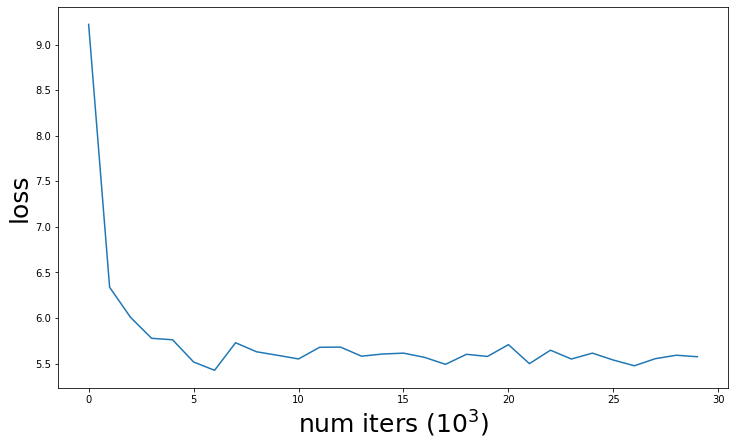

In [14]:
plt.figure(figsize=(12,7))
plt.plot(np.arange(30), losses)
plt.xlabel('num iters $(10^3)$', fontsize=25)
plt.ylabel('loss', fontsize=25)
plt.show()

In [0]:
layer = next(enumerate(model.modules()))[1]

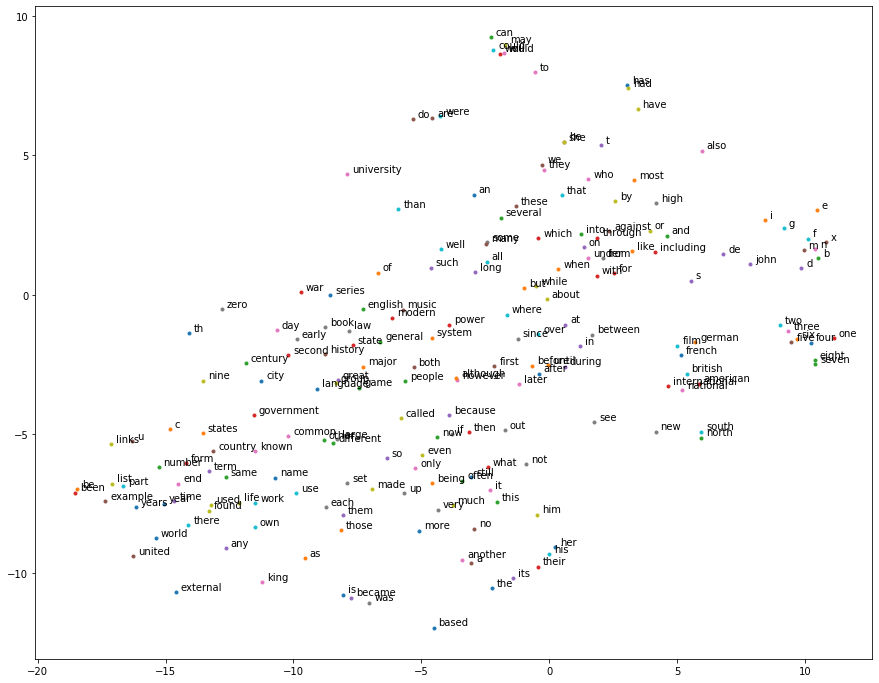

In [17]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

def plot_words(embs, labels):
    plt.figure(figsize=(15,12))
    for i, label in enumerate(labels):
        x, y = embs[i,:]
        plt.scatter(x,y, marker='.')
        plt.annotate(label, (x,y), xytext=(5,2), textcoords='offset points')

def onehot_tsne(batch, vocab_size):
    batch_onehot = torch.zeros(len(batch), vocab_size)
    for i, _ in enumerate(batch):
        if type(batch[i]) != type(0):
            for j in batch[i]:
                batch_onehot[i, j] = batch_onehot[i, j] + 1
        else:
            batch_onehot[i, batch[i]] = 1
    return batch_onehot

tsne = TSNE(n_components=2, init='pca', n_iter=10000)
num_words = 200
embs_to_plot = []
tags = []

for x, _ in counter_dict.most_common(num_words):
    v = onehot_tsne([word2idx[x]], vocab_size)
    v = v.to(device)
    embs_to_plot.append(layer(v).detach().cpu().numpy()[0])
embs_to_plot = tsne.fit_transform(np.array(embs_to_plot))

for word, _ in counter_dict.most_common(num_words):
    tags.append(word)

plot_words(embs_to_plot, tags)

Результаты хорошие. Если посмотреть на визуализацию, то можно увидеть ярко выраженные кластеры языков, чисел, местоимений, модальных глаголов и т.д.

# Intrisic & extrinsic evaluation.

In [0]:
layer = next(enumerate(model.modules()))[1]

In [0]:
def word_to_vector(word, layer=layer):
    vector = onehot_tsne([word2idx[word]], vocab_size).to(device)
    return layer(vector)

def cosine(a,b,layer):
  a = word_to_vector(a)[0]
  b = word_to_vector(b)[0]
  return (a @ b)/(torch.norm(a)*torch.norm(b)).item()

def similarity(words, vocabulary, word2vec, num_neighb=5):
    word_neighb = {}
    for word1 in words:
        similarity = {}
        for word2 in vocabulary:
            similarity[word2] = cosine(word1, word2, word2vec)
    most_similar = list(similarity.keys())
    most_similar.sort(reverse=True, key= lambda x: similarity[x])
    word_neighb[word1] = most_similar[1:num_neighb]
    return word_neighb

In [26]:
similarity(['russian'], vocab, layer)

{'russian': ['spanish', 'french', 'japanese', 'polish']}

In [27]:
similarity(['can'], vocab, layer)

{'can': ['cannot', 'must', 'may', 'could']}

In [28]:
similarity(['with'], vocab, layer)

{'with': ['from', 'through', 'beyond', 'towards']}